In [1]:
import pickle
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt

# read in all the data
trial_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_identification/2024-05-06_1715035356'
with open(os.path.join(trial_folder, 'experiment_config.yaml'), 'r') as f:
    experiment_config = yaml.load(f, yaml.Loader)
with open(os.path.join(trial_folder, 'hardware_config.yaml'), 'r') as f:
    hardware_config = yaml.load(f, yaml.Loader)
with open(os.path.join(trial_folder, 'data.pickle'), 'rb') as f:
    data = pickle.load(f)

In [4]:
from scipy.sparse import bsr_array
from scipy.optimize import lsq_linear
def calculate_dynamics(x,t):
    M = len(t)
    A_rows = np.hstack([np.array([2*i, 2*i, 2*i+1, 2*i+1]) for i in range(0,M-2)])
    A_cols = np.hstack([np.array([2*i, 2*i+1, 2*i, 2*i+1]) for i in range(0,M-2)]) 
    A_data = []
    b = np.zeros(2*(M-2))
    for i in range(M-2):
        dt = t[i]-t[i-1]
        A_data.append([-dt, .5*dt**2, dt, .5*dt**2])
        b[2*i] = x[i]-x[i+1]
        b[2*i+1] = x[i+2]-x[i+1]
    data = np.hstack(A_data)
    A_sparse = bsr_array((data,(A_rows,A_cols)), shape=(2*(M-2),2*(M-2)))
    result = lsq_linear(A_sparse, b)
    xdot = result.x[0:-1:2]
    xddot = result.x[1::2] 
    return xdot, xddot

In [5]:
# downsample the data and fit the dynamics
skip = 40
x = [np.array(arr[0::skip]) for arr in data['motor_angle']]
tau = [np.array(arr[0::skip]) for arr in data['motor_torque']]
l = [np.array(arr[0::skip]) for arr in data['hsa_len']]
dldx = [np.array(arr[0::skip]) for arr in data['dldtheta']]
t = [np.array(arr[0::skip]) for arr in data['times']]
psi = data['hsa_angle']
xdot = []
xddot = []
for i in range(len(x)):
    _xdot, _xddot = calculate_dynamics(x[i],t[i])
    xdot.append(_xdot)
    xddot.append(_xddot)

In [6]:
print(psi)

[-112.5, -87.50000000000001, -62.500000000000014, -37.499999999999964, -12.500000000000023, 12.500000000000023, 37.50000000000002, 62.500000000000014, 87.50000000000001, 112.5]


In [7]:
# pick 5 lengths uniformly from each trial
y = np.vstack(tuple([[_l, psi[i]] for _l in np.linspace(min(l[i]), max(l[i]), len(psi))] for i in range(len(psi))))
print(y.shape)

(100, 2)


In [8]:
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from hsa_hopper.hsa_model import HSAPotential

s = 2 # length scale for the Gaussian process regressor
v = np.zeros(y.shape[0])
potential = HSAPotential(v, y, s)

# stack all the data for access by a common index
_x = np.hstack([x[i][1:-1] for i in range(len(x))])
_t = np.hstack([t[i][1:-1] for i in range(len(x))])
_xdot = np.hstack(xdot)
_xddot = np.hstack(xddot)
_l = np.hstack([l[i][1:-1] for i in range(len(x))])
_dldx = np.hstack([dldx[i][1:-1] for i in range(len(x))])
_tau = np.hstack([tau[i][1:-1] for i in range(len(x))])
_psi = np.hstack([len(x[i])*[psi[i]] for i in range(len(x))])
# thats a pretty damn big system of equations
# lets assemble the A-matrix and b-vector
N = y.shape[0]
M = len(_x)
A = np.zeros((M,2+N))
b = np.zeros((M))
for i in range(M):
    b[i] = _tau[i]
    A[i,0] = _xddot[i]
    A[i,1] = _xdot[i]
    for j in range(N):
        z = np.array([_l[i], _psi[i]])
        A[i,2+j] = _dldx[i]*(potential.dk(z, j)[0])
ATA = A.T@A
ATb = A.T@_tau
bTb = _tau.T@_tau
f = lambda x: x.T@ATA@x+bTb-2*x.T@ATb
jac = lambda x: 2*ATA@x-2*ATb
hess = lambda x: 2*ATA

# next constraints - enforce positive weights
# and positive definiteness of stiffness at collocation points
C = np.zeros((2+N,2+N))
C[0,0] = 1
C[1,1] = 1
lb = np.zeros(2+N)
for j in range(N):
    z = y[j,:]
    K = [(potential.drho(z,k)@potential.drho(z,k).T-potential.d2rho(z,k))[0,0] for k in range(N)] 
    C[2+j,2:] = K

constraints = [LinearConstraint(C,lb=lb)]

x0 = np.zeros(2+N)
result = minimize(f, x0, 
                  jac=jac, 
                  hess=hess, 
                  constraints=constraints, 
                  method='trust-constr',
                  options={'maxiter' : 2000})

In [13]:
potential.v = result.x[2:]
with open(os.path.join('potential.yaml'), 'w') as f:
    yaml.dump(potential.attribute_dict(), f, yaml.Dumper)
print(result)

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 815.7119302522842
                 x: [ 9.951e-04  1.510e-01 ...  3.433e+02 -3.384e+02]
               nit: 560
              nfev: 652
              njev: 464
              nhev: 464
          cg_niter: 23740
      cg_stop_cond: 2
              grad: [ 4.069e-01 -3.403e-04 ... -3.212e-02 -2.639e-02]
   lagrangian_grad: [ 4.029e-07 -7.590e-06 ...  3.649e-03  1.292e-02]
            constr: [array([ 9.951e-04,  1.510e-01, ...,  3.160e+04,
                            5.672e+03])]
               jac: [array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           ...,
                           [ 0.000e+00,  0.000e+00, ..., -1.024e+03,
                            -9.579e+02],
                         

In [11]:
print(result.x[0:2])

[0.00099509 0.15103912]


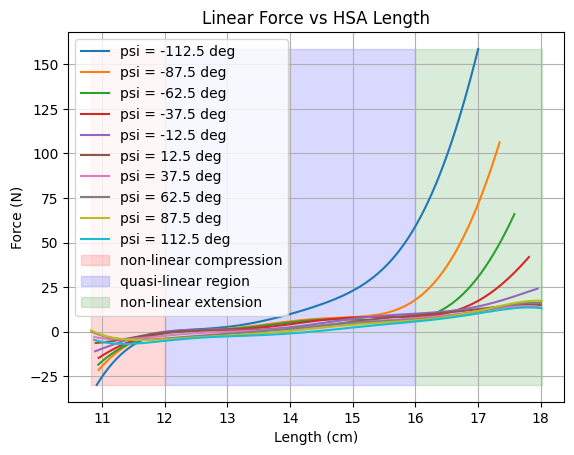

In [12]:
# plot this potential function for a range of theta values, fix psi = 0.

# for i in range(len(psi)):
fig, ax = plt.subplots()
# for i in range(len(psi)):
for i in range(0,len(psi)):
    _psi = psi[i]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(z[:,0]*100, [potential.dV(z[i,:])[0] for i in range(len(hsa_lens))], label=f'psi = {(_psi):.1f} deg')
ax.set_title('Linear Force vs HSA Length')
ax.set_xlabel('Length (cm)')
ax.set_ylabel('Force (N)')

xmin = min(min(line.get_xdata()) for line in ax.lines)
xmax = max(max(line.get_xdata()) for line in ax.lines)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compression')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.grid()
ax.legend()

0
2
4
6


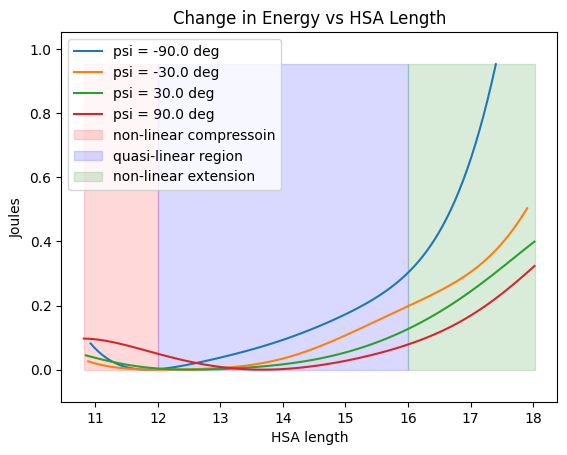

In [10]:
fig, ax = plt.subplots()
# for i in range(len(psi)):
for i in range(0,len(psi),2):
    print(i)
    _psi = psi[i]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(100*z[:,0], [potential.V(z[i,:]) for i in range(len(hsa_lens))], label=f'psi = {_psi:.1f} deg')
ax.set_title('Change in Energy vs HSA Length')
ax.set_xlabel('HSA length')
ax.set_ylabel('Joules')
for i, line in enumerate(ax.lines):
    ydata = np.array(line.get_ydata())
    ydata -= np.min(ydata)
    line.set_ydata(ydata)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compressoin')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.set_ylim([ymin-.1, ymax+.1])
# ax.legend(loc=[.35,.45])
ax.legend()

In [11]:
# print an energy heatmap
l_vec = np.linspace(.16,.18,20)
psi_vec = np.linspace(-61*np.pi/180,-30*np.pi/180, 20)
X,Y  = np.meshgrid(l_vec,psi_vec)
# Z1 = np.array([[ potential.V(np.array([X[i,j],Y[i,j]])) for j in range(X.shape[1])] for i in range(X.shape[0])])
Z2 = np.array([[ potential.dV(np.array([X[i,j],Y[i,j]]))[0] for j in range(X.shape[1])] for i in range(X.shape[0])])
Z3 = np.array([[ potential.d2V(np.array([X[i,j],Y[i,j]]))[0,0] for j in range(X.shape[1])] for i in range(X.shape[0])])
Z3 = np.clip(Z3, 1, np.inf)

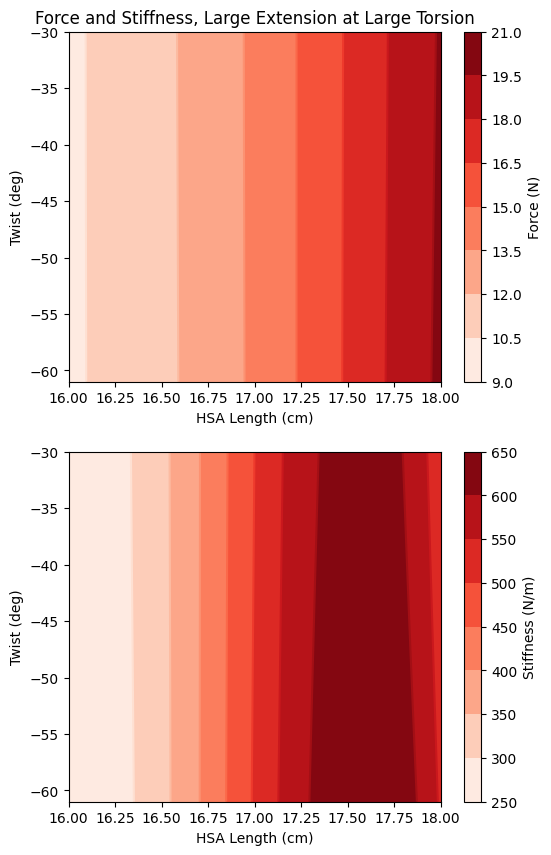

In [12]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,10))
CS11 = ax[0].contour(100*X,180*Y/np.pi,Z2, cmap='Reds')
CS12 = ax[0].contourf(100*X,180*Y/np.pi,Z2, cmap='Reds')
CS21 = ax[1].contour(100*X,180*Y/np.pi,Z3, cmap='Reds',)
CS22 = ax[1].contourf(100*X,180*Y/np.pi,Z3, cmap='Reds',)
ax[0].set_title('Force and Stiffness, Large Extension at Large Torsion')
ax[0].set_ylabel('Twist (deg)')
ax[1].set_ylabel('Twist (deg)')
ax[0].set_xlabel('HSA Length (cm)')
ax[1].set_xlabel('HSA Length (cm)')
fig.colorbar(CS12, label='Force (N)')
fig.colorbar(CS22, label='Stiffness (N/m)')

In [13]:
from scipy.optimize import root_scalar
# code to find rest length of HSA as a function of twist

def R(psi, bracket):
    f = lambda l, psi: potential.dV(np.array([l, psi]))[0]
    sol = root_scalar(f, (psi,), method='bisect', bracket=bracket, xtol = 1e-9)
    return sol.root

In [14]:
from scipy.optimize import minimize, LinearConstraint
omega = (5*np.pi)
mass = np.array([1.2, 1.8, 2.2])
E = np.array([m*9.81*.04 for m in mass])
K_sys = np.array([m*omega**2 for m in mass])
K_ground = np.array([10000, 5000, 2000, 1000])
K_leg = np.array([[1/(1/K1-1/K2) for K2 in K_ground] for K1 in K_sys])
dx = np.array([
    [np.sqrt(2*E[i]/K_leg[i,j]/(1+K_leg[i,j]/K_ground[j])) for j in range(len(K_ground))] 
    for i in range(len(E))
])
E_leg = np.array([
    [.5*K_leg[i,j]*dx[i,j]**2 for j in range(dx.shape[1])]
    for i in range(dx.shape[0])
])

# lots and lots of analysis
def F(z, dx, E_leg):
    # get rest length
    l0 = z[0]
    l1 = l0 + dx
    z0 = np.array([l0, z[1]])
    z1 = np.array([l1, z[1]])
    E = potential.V(z1)-potential.V(z0)
    f = (E - E_leg)**2

    # calculate gradient wrt psi
    dE = potential.dV(z1)-potential.dV(z0)
    return f, 2*(E-E_leg)*dE

result = np.zeros((2,*dx.shape))
for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
        z0 = [R(0., [.11,.18]),10*np.pi/180]
        constraints = [
            LinearConstraint(np.array([1,0]),lb=.1,ub=.1825-dx[i,j]),
            LinearConstraint(np.array([0,1]),lb=-60*np.pi/180,ub=np.pi/4)
        ]
        sol = minimize(F,z0,args=(dx[i,j],E_leg[i,j]),method='SLSQP',jac=True,constraints=constraints)
        result[:,i,j] = sol.x
        print(sol)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.699172277332055e-08
       x: [ 1.256e-01  1.745e-01]
     nit: 4
     jac: [-6.289e-03  6.118e-07]
    nfev: 4
    njev: 4
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.2255341703252273e-07
       x: [ 1.266e-01  1.745e-01]
     nit: 4
     jac: [-1.763e-02  1.587e-06]
    nfev: 4
    njev: 4
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.2027977082420657e-08
       x: [ 1.295e-01  1.745e-01]
     nit: 5
     jac: [ 6.158e-03 -4.626e-07]
    nfev: 5
    njev: 5
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.2248175549268906e-07
       x: [ 1.341e-01  1.743e-01]
     nit: 4
     jac: [-9.916e-03  6.668e-07]
    nfev: 5
    njev: 4
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0313722506723464
       x: [ 1.286e-01  1.739e-01]
     nit: 2
     jac

In [15]:
# print(sol.x*180/np.pi)
# print(R(sol.x, [.1,.18])+dx[1,2])
print(result[0,:,:])
print(result[0,:,:]+dx)
print(result[1,:,:]*180/np.pi)

[[0.12562739 0.12659096 0.12952032 0.1340874 ]
 [0.12860732 0.13111212 0.1386265  0.14943318]
 [0.12916394 0.13222536 0.1414096  0.15671667]]
[[0.18035499 0.1796487  0.17756848 0.17378624]
 [0.1825     0.1825     0.1825     0.18078272]
 [0.1825     0.1825     0.1825     0.1825    ]]
[[  9.99835132   9.99949526  10.0005778    9.98869694]
 [  9.96291285   9.9668605    9.95929541   9.96554496]
 [-60.         -60.           9.93951176   9.97132072]]
